# Text Summarization
Nowadays, AI can do anything, it can classify images, it can write articles, it can create images and also summarize texts! So in this code we are getting into
 text summarization. This notebook is the data loading and model training of this application. The GUI app is available in the release page. There are many steps towards implemeting this project. However, the main one is the model structure. In this type of applications, the input and output are both sequences. These types of models are called **Seq2Seq** models. More on that in the model creation part.
 <br>
## Steps:


1.   **Setup**
2.   **Data prepration**
      * Reading the data
      * Preprocessing
3.   **Model and Training**
      * Setup training
      * Model creation
      * Training
4.   **Evaluation and testing**


---



# Setup
Loading and setting up libraries for the training process

In [1]:
# import all libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
from nltk.corpus import stopwords
import numpy as np
import pandas as pd 
import re
from sklearn.model_selection import train_test_split as tts
from bs4 import BeautifulSoup
from attention import AttentionLayer
import matplotlib.pyplot as plt
import pickle

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
stop_words = set(stopwords.words('english')) 

In [4]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Data Prepration
The data which is going to be used for the training process is the CNN Daily Mail with it's summaries. This data is downloaded via the following link: <br>
THE LINK<br>
This data containes many columns, but all of all of them are going to be dropped excpet `text` and `summary ` as these are the inputs and outputs. In the first part of this process, the `.csv` file named `data.csv` is going to be loaded and as mentioned, all the useless columns will be removed using `pd.drop()`. In the preprocessing step, First the data is going to be cleared. The contractions will be mapped, All stopwords will be deleted and everything will get clean for the rest of the project. After, we are going to remove outliers. They are basically datas that are out of the ranges. More details will be provided in its dedicated section. At the end, the data will be splited and everything will get tokenized.

## Data Loading


In [5]:
# load the data
df = pd.read_csv("data/Reviews.csv", nrows=250000)

In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [7]:
# Drop Duplicates and NAs
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197824 entries, 0 to 249902
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      197824 non-null  int64 
 1   ProductId               197824 non-null  object
 2   UserId                  197824 non-null  object
 3   ProfileName             197824 non-null  object
 4   HelpfulnessNumerator    197824 non-null  int64 
 5   HelpfulnessDenominator  197824 non-null  int64 
 6   Score                   197824 non-null  int64 
 7   Time                    197824 non-null  int64 
 8   Summary                 197824 non-null  object
 9   Text                    197824 non-null  object
dtypes: int64(5), object(5)
memory usage: 16.6+ MB


## Preprocessing
To preprocess the dataset, there are several things that should be done. First, the data must be cleaned. All of the stopwords, symbols, etc should be removed and contraction mapping should be done. After this, we should split the data for tokenization. It will be tokenized and ready for the model's training.

### Text Cleaning
In thie section, first the text will be cleaned. after that outliers will be removed and then everything will get ready for the next step

In [9]:
# define a dictionary for contracition mapping 
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
def text_cleaner(text, num):
    """
    This function cleans a text by removing everything :)
    """
    # define new string 
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)

    # Clean texts with number 0
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]

    # Clean Summaries with number 1
    else:
        tokens=newString.split()
    
    long_words = []
    for i in tokens:
        if len(i) > 1:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

The `text_cleaner()` function gets to parameters. One is the text which is going to be cleaned and the other is a number. In here, 0 indates that the function should clean the main text and 1 cleaning the summary.
We are going to define 2 seperate lists, one for cleaned texts and another for cleaned summary. Then a dataframe will be made with both of them.

In [11]:
# clean the text 
cleaned_texts = []

for t in df["Text"]:
    cleaned_texts.append(text_cleaner(t, 0))

In [12]:
# clean summaries
cleaned_summaries = []

for s in df["Summary"]:
    cleaned_summaries.append(text_cleaner(s, 1))

In [13]:
# create new dataframe for the cleaned texts and summaries 
dataframe = pd.DataFrame(columns=["text", "summary"])
# put cleaned version of texts and summaries into the dataframe
dataframe["text"] = cleaned_texts
dataframe["summary"] = cleaned_summaries

In [14]:
dataframe

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...
197819,yes picture incorrect get two packs single packs total single packs right complain cheap honestly always thought getting powders two sticks rip kid really recommend posting picture real product ge...,wrong picture but still cheap
197820,purchasing keep mind picture dishonest misleading shows flavor pack two lik sticks yet received fun dip individual flavor packs one lik stick per flavor misleading purchased idea would flavors two...,misleading picture
197821,picture shows fun dip triple pack comes flavors two sticks sent got single packs late return need halloween change picture amazon,not as pictured
197822,dog loves first adopted would eat expensive tried several brands found much cheaper brand wal mart places loves,yummy for dogs but expensive


In [15]:
dataframe.replace('', np.nan, inplace=True)
dataframe.dropna(axis=0,inplace=True)

In [16]:
# define text and summary max lengths 
MAX_TEXT_LEN = 50
MAX_SUMMARY_LEN = 10

### Just keep summaries and text within limits 
To have better training, we are going to remove outliers. Outliers are the datas that are really outside of what we want. In this case texts that are more than 70 words and summaries more than 10 words.

In [17]:
# make the texts and summaries some arrays
cleaned_text = np.array(dataframe["text"])
cleaned_summary = np.array(dataframe["summary"])

# define lists for short text and short summaries
short_text = []
short_summary = []

# clean outliers
for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

# change the dataframe
final_dataframe = pd.DataFrame({"text":short_text, "summary":short_summary})

## Adding Tokens
We add `soseq ` token to the start of the sequence and the `eoseq ` token to the end of it


In [18]:
final_dataframe["summary"] = final_dataframe["summary"].apply(lambda x: "soseq " + x + " eoseq")

In [19]:
# print wome sample of the dataframe
for i in range(3):
  print("\033[1m" + "Text: " + "\033[0m" + final_dataframe["text"][i])
  print("\033[1m" + "Summary: " + "\033[0m" + final_dataframe["summary"][i])
  print("\n")

Text: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: soseq good quality dog food eoseq


Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: soseq not as advertised eoseq


Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: soseq delight says it all eoseq




## Split data into train, test and validation 
10 percent of data will be used for validation and 5 percent for testing. The left 85% will be dedicated to training.
First of, We are going to dedicate 15% for validation and we will select the 5% from the validation data. 

In [20]:
# define arrays for datas 
texts = np.array(final_dataframe["text"])
summaries = np.array(final_dataframe["summary"])

In [21]:
# devide train and validation
x_train, x_val, y_train, y_val = tts(texts, summaries, test_size=0.15, random_state=0, shuffle=True)

In [22]:
# divide test data from the validation data
x_val, x_test, y_val, y_test = tts(x_val, y_val, test_size=0.05, random_state=0, shuffle=True)

## Tokenization
Tokenizing means assigning a number to each word. To do this, first we calculate the number of common words in both inputs and outputs. By this we can tokenize the top most commont words. After that we tokenize and do zero padding. By zero padding we make the length of all sequences the same so all lengths are equal. In the last paer we delete words that only contain `soseq` and `eoseq` and no other thing.

### Input data tokenization

In [23]:
# define the x tokenizer 
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [24]:
# define the threshold
threshold = 4

# define variables for total count, count, frequency and total frequency
count = 0 # Number of rare words 
total_count = 0 # count of every unique word in texts 
freq = 0 
total_freq = 0

for key, value in x_tokenizer.word_counts.items():
  # update counts and frequencies
  total_count += 1
  # if the value of word was lower than our threshold, count!
  if value < threshold:
    count += 1

In [25]:
# get the top most common words number 
common_words = total_count - count 

# fit the tokenizer 
x_tokenizer = Tokenizer(num_words=common_words)
x_tokenizer.fit_on_texts(list(x_train))

# convert text sequence to int
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

# Zero padding 
x_train = pad_sequences(x_train_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_test = pad_sequences(x_test_seq, maxlen=MAX_TEXT_LEN, padding="post")

# get the size of input vocabulary
x_vocab = x_tokenizer.num_words + 1

In [26]:
print(f"size of input (X) vocabulary: {x_vocab}")

size of input (X) vocabulary: 17209


### Output data tokenization

In [27]:
# define the tokenizer 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [28]:
# define the threshold
threshold = 6

# define variables for total count, count, frequency and total frequency
count = 0 # Number of rare words 
total_count = 0 # count of every unique word in texts 
freq = 0 
total_freq = 0

for key, value in y_tokenizer.word_counts.items():
  # update counts and frequencies
  total_count += 1
  # if the value of word was lower than our threshold, count!
  if value < threshold:
    count += 1

In [29]:
# get the count of common words
common_words = total_count - count 

# fit tokenizer on common words
y_tokenizer = Tokenizer(num_words=common_words)
y_tokenizer.fit_on_texts(list(y_train))

# convert text sequence to int
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

# Zero padding 
y_train = pad_sequences(y_train_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_val = pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_test = pad_sequences(y_test_seq, maxlen=MAX_SUMMARY_LEN, padding="post")

# get the size of output vocabulary
y_vocab = y_tokenizer.num_words + 1

In [30]:
print(f"size of output (Y) vocabulary: {y_vocab}")

size of output (Y) vocabulary: 4184


### Remove rows with only start and end tokens (Cleaning part)
There are some summaries that just start with `soseq ` amd `eoseq `. We are going to remove them because they are useless. We know that if a summary contains a text, it should have more than 2 words (because of start and end tokens), So to do this we say that if there are just 2 words in the row, remove it. We do this process for train, test and validation datas. 

#### Train data

In [31]:
# define a list for index 
index = []

# loop over train data 
for i in range(len(y_train)):
    count = 0
    for j in y_train[i]:
        if j != 0:
            count += 1
        # if count of words were 2, remove the data
    if count == 2:
        index.append(i)

# remove rows
y_train = np.delete(y_train, index, axis=0)
x_train = np.delete(x_train, index, axis=0)

#### Validation data

In [32]:
# define a list for index 
index = []

# loop over train data 
for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count += 1
        # if count of words were 2, remove the data
    if count == 2:
        index.append(i)

# remove rows
y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

#### Test data 

In [33]:
# define a list for index 
index = []

# loop over train data 
for i in range(len(y_test)):
    count = 0
    for j in y_test[i]:
        if j != 0:
            count += 1
        # if count of words were 2, remove the data
    if count == 2:
        index.append(i)

# remove rows
y_test = np.delete(y_test, index, axis=0)
x_test = np.delete(x_test, index, axis=0)

In [34]:
x_train[0]

array([   5,   38,    3, 2870,  146, 1497,   21, 4763,  698, 2033, 1868,
        275, 2033, 1868, 2033, 5101,  967, 4014, 1760, 1981,   37, 5479,
          5, 3216,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [35]:
# setup the datas for training
x_train_m = [x_train, y_train[:,:-1]]
y_train_m = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
x_val_m = [x_val, y_val[:,:-1]]
y_val_m = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

# 
Model and Training
Now the data is ready and we are going to start training the model. In this project we have a sequence as our input and a sequence for our output and because of that, we call the model Seq2Seq (Sequence to Sequence). We implement the seq2seq model using LSTM-RNN. First we define the input. The input goes to the encoder. The state of the encoder gets to the decoder. Then the result of the decoder goes to a attention layer. This layer gets the main focus of the subject and adjust the weights and biases. This image is a simple example of a Seq2Seq model:
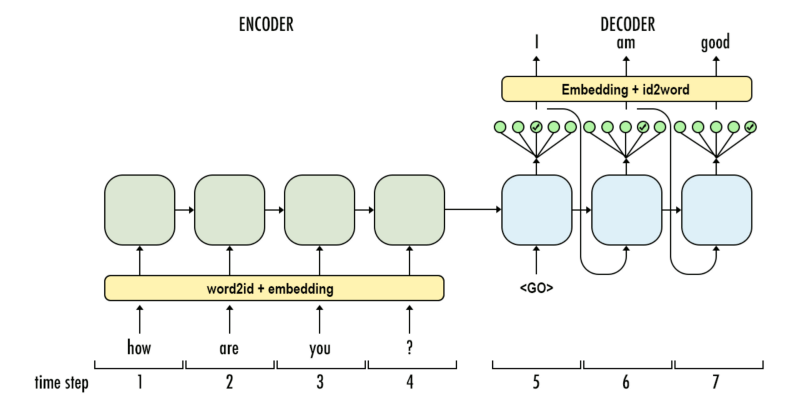

In [36]:
# define hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
LATENT_DIM = 250
EMBED_DIM = 90

## Model Building

In [37]:
# -------------------------------------------------------------------- < Encoder > --------------------------------------------------------------------
# define the input 
encoder_input = Input(shape=(MAX_TEXT_LEN, ), name="encoder_input")

# Embedding 
encoder_embed = Embedding(x_vocab, EMBED_DIM, trainable=True, name="encoder_embeding")(encoder_input)

# Encoder LSTM Block 1
encoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_1")
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)

# Encoder LSTM Block 2
encoder_lstm2 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_2")
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM Block 3
encoder_lstm3 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_3")
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# -------------------------------------------------------------------- < Decoder > --------------------------------------------------------------------
# define the input 
decoder_input = Input(shape=(None, ), name="decoder_input")

# Embedding for Decoder 
decoder_embed_layer = Embedding(y_vocab, EMBED_DIM, trainable=True)
decoder_embed = decoder_embed_layer(decoder_input)

# Decoder LSTM
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="decoder_lstm")
decoder_lstm_output, decoder_h1, decoder_c1 = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

# Attention Layer 
attention_layer = AttentionLayer(name="attention_layer")
attention_output, attention_state = attention_layer([encoder_output3, decoder_lstm_output])

# concatinate decoder and attention otuputs 
decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output, attention_output])

# Time Distributed Dense 
decoder_dense = TimeDistributed(Dense(y_vocab, activation="softmax"))
decoder_output = decoder_dense(decoder_concat)

# define the final model
model = Model([encoder_input, decoder_input], decoder_output)

In [38]:
# see the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 50)]         0           []                               
                                                                                                  
 encoder_embeding (Embedding)   (None, 50, 90)       1548810     ['encoder_input[0][0]']          
                                                                                                  
 enc_lstm_1 (LSTM)              [(None, 50, 250),    341000      ['encoder_embeding[0][0]']       
                                 (None, 250),                                                     
                                 (None, 250)]                                                     
                                                                                              

In [39]:
# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [40]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=0.0001)

## Model Training

In [41]:
# Uncomment if want to continue training or load model
model.load_weights("Model Weights/weights")

In [85]:
history = model.fit(x_train_m, y_train_m, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_m, y_val_m), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
497/497 [==============================] - 483s 954ms/step - loss: 2.5416 - accuracy: 0.6261 - val_loss: 2.2910 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 2/50
497/497 [==============================] - 470s 946ms/step - loss: 2.2271 - accuracy: 0.6524 - val_loss: 2.1313 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 3/50
497/497 [==============================] - 470s 946ms/step - loss: 2.0874 - accuracy: 0.6643 - val_loss: 2.0247 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 4/50
497/497 [==============================] - 471s 948ms/step - loss: 2.0015 - accuracy: 0.6712 - val_loss: 1.9610 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 5/50
497/497 [==============================] - 471s 949ms/step - loss: 1.9370 - accuracy: 0.6764 - val_loss: 1.9118 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 6/50
497/497 [==============================] - 477s 959ms/step - loss: 1.8868 - accuracy: 0.6807 - val_loss: 1.8840 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 7/50
497/497 [==========================

In [111]:
# save model and it's weights
#model.save_weights("Model Weights/weights")

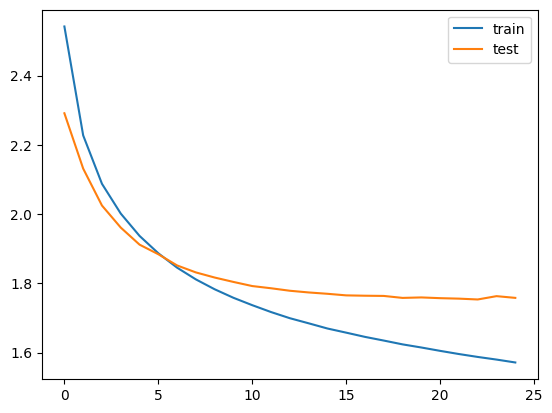

In [87]:
# fraw plots 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Model Testing and Evaluation

Now the model is trained we are going to test and evaluate the model. To do this first we are going to make the trained layers prepared for single prediction. Then, Some functions should be defined that transform sequences to texts and texts to sequences! At the end, we are going to define a function for single prediction.

In [74]:
# save the tokenizer 
with open('xtokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Ready layers for prediction

In [42]:
# set tokenizerz for predictions
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [44]:
# define s single model for encoder
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

# ---------- < DECODER > ----------
# define inputs 
decoder_input_state_h = Input(shape=(LATENT_DIM, ))
decoder_input_state_c = Input(shape=(LATENT_DIM, ))
decoder_input_state_hidden = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))

# Embedding of the decoder 
decoder_embedding_pred = decoder_embed_layer(decoder_input)
# Decoder LSTM (For making prediction, the state of the decoder should be set to the state of its previos time step)
decoder_output_p, state_h_p, state_c_p = decoder_lstm(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])

# Attention
attention_out_inference, attention_state_inference = attention_layer([decoder_input_state_hidden, decoder_output_p])
decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p, attention_out_inference])

# Final prediction
decoder_final_output = decoder_dense(decoder_concat)

# make the final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c],
    [decoder_final_output] + [state_h_p, state_c_p])

### Sequence decoding
The way that the model makes prediction is that, the encoder predicts, then the prediction of the encoder gets decoded and this should be done using a function

In [64]:
def sequence_decoder(input_sequence):
    """
    This function decods the sequence predicted
    """
    # encode the input 
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)
    # Define an embpy target with it's first woed set to input sequence 
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_word_index["soseq"]

    # define variables for when to stop and the decoded sentence
    decoded_sentence = ""
    stop = False

    while not stop:
        # when we did not reach the place to stop (eoseq), decode 
        output_token, h, c = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c], verbose=None)

        # predict token
        predicted_token_index = np.argmax(output_token[0, -1, :])
        predicted_token = reverse_target_word_index[predicted_token_index]
        
        # if the token was not end of sequence, continue and add the predicted token to the dcecoded sentence variable 
        if  predicted_token != "eoseq":
            decoded_sentence += " " + predicted_token

        # if we've reached eoseq token or reached the summary length limit, make the stop state true 
        if predicted_token == "eoseq" or len(decoded_sentence.split()) >= MAX_SUMMARY_LEN - 1:
            stop = True

        # update the target sequence 
        target_sequence = np.zeros((1,1))
        target_sequence[0, 0] = predicted_token_index

        # Update internal states
        encoder_h, encoder_c = h, c

    return decoded_sentence

In [65]:
def sequence_to_summary(input_seuqnece):
    """
    This function converts sequence into text (in this case summary)
    """
    sentence = ""
    # loop over the input sequence 
    for i in input_seuqnece:
        if i != 0 and i != target_word_index["soseq"] and i != target_word_index["eoseq"]:
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [66]:
def sequence_to_text(input_seuqnece):
    """
    This function converts sequence into text (in this case text)
    This function is going to be used only for testing the model on test data 
    """
    sentence = ""
    # loop over the input sequence 
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [68]:
for i in range(50, 55):
    print("Review:", sequence_to_text(x_test[i]))
    print("Original summary:", sequence_to_summary(y_test[i]))
    print("Predicted summary:", sequence_decoder(x_test[i].reshape(1,MAX_TEXT_LEN)))
    print("\n")

Review: delightful item place bottom champagne added sweet twist holiday party made drink look wonderful loved well priced 
Original summary: price ever 
Predicted summary:  delicious


Review: found health stores markets shop gotten reg pretzels brand sourdough taste sourdough flavor much salt excited find getting bit disappointment also label says spelt concern mine eating wheat spelt pretzels 
Original summary: great local 
Predicted summary:  good pretzels


Review: assuming reading review realize instant coffee know means us like prefer ease instant coffee make strong weak like mint chocolate good job masking fact instant coffee one potentially negative comment would mint fresh strongest flavors 
Original summary: little nutritious little water way go better 
Predicted summary:  it is ok


Review: almond accents oz bags used sold costco stopped carrying happy sold amazon meeting price quality requirements 
Original summary: olive texture 
Predicted summary:  great product


Review